In [1]:
import os, glob, json
import pickle
import pandas as pd
pd.set_option('display.max_colwidth', None)
pd.set_option('display.max_rows', None)

import seaborn as sns
import matplotlib.pyplot as plt
from datetime import datetime
import re
import numpy as np
from scipy import stats
from collections import Counter, defaultdict
import random, math
from tqdm import tqdm
import platform

# print machine name
machine_name = platform.node().split(".")[0]
print(machine_name)

# print available scratch directories
print(" ".join(os.listdir(f"/{machine_name}")))
scr_dir = os.listdir(f"/{machine_name}")[0]

DISK_IO_DIR = "/{}/{}/yiweil".format(machine_name,scr_dir)
print(DISK_IO_DIR)
if not os.path.exists(DISK_IO_DIR):
    os.mkdir(DISK_IO_DIR)
    
from utils import *
print(STANZA_DIR)

john10
scr1
/john10/scr1/yiweil
Using Δ|&#8710;|∆|!delta as regex for comments awarding delta.
Found 422 conversations which are manually checked to be true climate convos.
/nlp/u/yiweil/combined_stanza_output_with_ner_embed_removed


In [2]:
# DELTAS = ['Δ','&#8710;','∆','!delta']
# DELTA_REGEX = r'{}'.format('|'.join(DELTAS))
# print(DELTA_REGEX)

# def awarding_delta(utt, delta_regex=DELTA_REGEX):
#     """
#     Checks whether a comment is a true comment; was not written by DeltaBot; and is awarding a delta.
#     """
#     return (utt.id[:2]=='t1') \
#             and (utt.speaker.id != 'DeltaBot') \
#             and (len(re.findall(DELTA_REGEX, utt.text)) > 0)

# def is_leaf(utt):
#     """
#     Returns whether a comment is a terminal "leaf" comment or not.
#     """
#     return (utt.id[:2] == 't1') and (len(utt.meta['reply_ids']) == 0)

# paths_toward_utts_dict = pickle.load(open('paths_toward_utts_dict.pkl','rb'))
# def get_path_to_utt(utt, inclusive=True):
#     """
#     Returns the path of comment IDs leading from the first, top-level comment to the argument utt (inclusive
#     by default). 
#     """
#     if inclusive:
#         return paths_toward_utts_dict[utt.id][1:]+[utt.id]
#     else:
#         return paths_toward_utts_dict[utt.id][1:]

# def get_depth_in_subtree(utt):
#     """
#     Returns the depth of a comment within a sub-tree (0 means OP; 1 means top-level comment, etc.)
#     """
#     if utt.id[:2] == 't3':
#         return 0
#     else:
#         return len(paths_toward_utts_dict[utt.id][1:])+1 # empty > 0 for top-level

# Load/annotate ConvoKit corpus

Available corpora to load:
* entirety of r/changemyview from inception to 9/24/2021 (`full_cmv`)
* comments-only subset of r/changemyview where comments w/ and without deltas have been evenly matched for length, depth, elapsed time, etc. (`matched_cmv_subsample`)
* subset of the above, further subsetted to comments attached to climate-change-related posts (`matched_cc_cmv_subsample`)
* random sample of posts & comments from top 100 high-activity subreddits (`gen_reddit`)
* switchboard corpus

In [5]:
from convokit import Corpus#, Speaker, download
AVAILABLE_CORP = ['full_cmv','matched_cmv_subsample','gen_reddit','switchboard']
corp_name_to_filepath = {
                         'full_cmv': '/u/scr/yiweil/convokit_corpora/my-cmv-corpus_1-1-2010_to_09-24-2021',
                         'matched_cmv_subsample': '/u/scr/yiweil/subsampled_cmv_corpus',
                         'gen_reddit':'/u/scr/yiweil/datasets/convokit/reddit-corpus-small',
                         'switchboard':'/sailhome/yiweil/.convokit/downloads/switchboard-corpus'
                        }

In [6]:
corp_to_analyze = {'full_cmv': None}#,'gen_reddit': None,'switchboard':None}
#corp_to_analyze.update({'matched_cmv_subsample': None})

for corp_name in corp_to_analyze:
    if corp_to_analyze[corp_name] is None:
        print("Loading corpus: {}...".format(corp_name))
        corp_to_analyze[corp_name] = Corpus(filename=corp_name_to_filepath[corp_name])
        corp_to_analyze[corp_name].print_summary_stats()
        print('\n')
        
        # Update full meta for conversations if corpus is not `matched_cc_cmv_subsample` (contains comments only, by design)
        if corp_name in {'full_cmv','matched_cmv_subsample','gen_reddit','switchboard'}:
            for utt in corp_to_analyze[corp_name].iter_utterances():
                if utt.id == utt.conversation_id: # not a comment but a post
                    convo = corp_to_analyze[corp_name].get_conversation(utt.id)
                    meta_dict = utt.meta
                    for key in meta_dict:
                        convo.add_meta(key, meta_dict[key])
                    convo.speaker = utt.speaker
                        
        print("Annotating {}...".format(corp_name))
        corp_to_analyze[corp_name] = filter_bots_mods_removed(corp_to_analyze[corp_name])
        print('\n')
        
        if corp_name in {'matched_cmv_subsample','matched_cc_cmv_subsample'}:
            print("Annotating generic utterances from {}...".format(corp_name))
            corp_to_analyze[corp_name] = filter_generic_comments(
                corp_to_analyze[corp_name], 
                GENERIC_REGEX_PATS,
                fname=f'generic_dict_{corp_name}.pkl')
            corp_to_analyze[corp_name].print_summary_stats()
            print('\n')
            
        print("Removing footnotes and in-line embedded text from {}...".format(corp_name))
        for utt in tqdm(corp_to_analyze[corp_name].iter_utterances()):
            utt.text = cleanup(utt.text)
            
#         if corp_name in {'full_cmv', 'matched_cmv_subsample', 'matched_cc_cmv_subsample'}:
#             print("Adding delta information...")
#             for utt in tqdm(corp_to_analyze[corp_name].iter_utterances()):
#                 #utt.meta['is_awarded_delta'] = is_awarded_delta(utt.id)
#                 #utt.meta['num_deltas'] = num_deltas(utt.id)
#                 utt.meta['is_awarding_delta'] = awarding_delta(utt)
        
        print("Distribution of delta outcomes:")
        print(Counter([utt.meta['outcome'] for utt in corp_to_analyze['full_cmv'].iter_utterances()
              if utt.id[:2]=='t1']))

Loading corpus: full_cmv...
Number of Speakers: 207110
Number of Utterances: 3243830
Number of Conversations: 84258


Annotating full_cmv...
Filtering speakers with usernames ending in '-bot'...
Found 2896720 non-deleted/removed utterances not written by a bot or moderator.


Removing footnotes and in-line embedded text from full_cmv...


3243830it [01:24, 38441.13it/s]


Distribution of delta outcomes:
Counter({-1: 1919491, '-delta': 1204715, '+delta': 35366})


In [100]:
print(corp_to_analyze['full_cmv'].get_conversation('t3_1xx3cl').meta['title'])
print(corp_to_analyze['full_cmv'].get_utterance('t3_1xx3cl').text)

Australia is the best country in the world CMV
Australia has a strong tradition of an honest days pay for an honest days work. We have a strong union presence which leads to high wages backed by a strong resource economy. We also have a very multicultural society with many immigrants choosing to settle in Australia this leads to diverse shopping areas where goods originally made all over the world are made right here on our shores. The main reason Australia is the best country in the world is our heavily ingrained concept of a "fair go" meaning you give anybody a chance to prove themselves no matter who they are. This is not even mentioning our spectacular landscapes and beaches. All in all Australia is the best country in the world.      


In [95]:
corp_to_analyze['full_cmv'].get_utterance('t3_a490vw').text

"The Airlines in the US are overpriced, overbooked, and have bad service. Everyone I know prefers foreign Airlines. So why can't we allow them to fly in the United States. I mean, I think I know why - it's because of protectionist policies. But so long as these airlines are held accountable to the same regulations as domestic airlines, and pay taxes and whatever, wouldn't it be a good thing to bring in more competition? I'm sure cheaper and better flight service would have positive net externalities as well. CMV\n"

## One-off: annotate +/-delta outcomes

In [12]:
# Annotate entire sub-trees for +/- delta

# 2 cases:
# 1. sub-tree leads to a +delta outcome (someone awards a delta) > want to retrieve 
# everything leading up to this comment as a +delta datapoint
# 2. sub-tree does not have any comments awarding deltas > want to retrieve 
# everything leading up to final leaf node as a -delta datapoint 
# (can choose to post-hoc truncate to match depth of +delta datapoints)

# We ignore all sub-trees branching out from comments awarding delta 
# (outcome has already been reached, no reason to look beyond)

# for every comment (excluding children of comments awarding deltas; post-outcome), 
# check if it's one that's awarding a delta:
#     if True:
#          do: get everything leading up to it as a +delta datapoint
#     elif False AND it's a leaf node: # AND nowhere above it was a delta awarded:
#          do: get everything leading up to it as a -delta datapoint
#     else: 
#          means that comment isn't an outcome, so no need to get path to it as a datapoint

delta_awarding_comment_ids = set([utt.id for utt in corp_to_analyze['full_cmv'].iter_utterances()
                                  if utt.meta['is_awarding_delta']])
children_delta_awarding_comments = set(flatten([corp_to_analyze['full_cmv'].get_utterance(utt_id).meta['reply_ids']
                                                for utt_id in delta_awarding_comment_ids]))
print(f"Found {len(delta_awarding_comment_ids)} comments awarding a delta, which collectively have \
{len(children_delta_awarding_comments)} child nodes.")

Found 35501 comments awarding a delta, which collectively have 56988 child nodes.


In [14]:
for utt in tqdm(corp_to_analyze['full_cmv'].iter_utterances()):
    if utt.id[:2] == 't1':
        if utt.id in children_delta_awarding_comments: # ignore these post-outcome nodes
            utt.meta['path_to_outcome'] = -1
            utt.meta['outcome'] = -1
        else:
            is_awarding = utt.meta['is_awarding_delta']
            if is_awarding:
                utt.meta['path_to_outcome'] = get_path_to_utt(utt)
                utt.meta['outcome'] = '+delta'
            elif (not is_awarding) and is_leaf(utt):
                utt.meta['path_to_outcome'] = get_path_to_utt(utt)
                utt.meta['outcome'] = '-delta'
            else: 
                utt.meta['path_to_outcome'] = -1 # ignore non-outcome nodes
                utt.meta['outcome'] = -1
            
Counter([utt.meta['outcome'] for utt in corp_to_analyze['full_cmv'].iter_utterances()
         if utt.id[:2]=='t1'])

3243830it [01:20, 40435.16it/s]


Counter({-1: 1919491, '-delta': 1204715, '+delta': 35366})

In [15]:
35366/1204715 # 3% of outcomes are +delta, remaining 97% are -delta

0.029356320789564336

## Save corpus with annotations

In [16]:
corp_to_analyze['full_cmv'].dump('my-cmv-corpus_1-1-2010_to_09-24-2021','/u/scr/yiweil')

## Prepare corpus for stanza parsing

In [ ]:
# Write sub-tree text for parsing
# Don't want to concatenate everything yet, in case we want to truncate at certain depths later
# Fields: comment ID, text

STANZA_DIR = '/nlp/u/yiweil/combined_stanza_output_with_ner_embed_removed'
all_processed = glob.glob(STANZA_DIR+'/*.json') #\
                #+ glob.glob('/nlp/u/yiweil/combined_stanza_output_with_ner_embed_removed'+'/*.json')
processed_utt_ids = set([x.split('/')[-1].split('.json')[0] for x in all_processed])
print(f"Found {len(processed_utt_ids)} IDs already processed.")
non_empty_utt_ids = set([utt.id for utt in corp_to_analyze['full_cmv'].iter_utterances()
                         if not is_empty_utt(utt)])

missing_ids = list(non_empty_utt_ids.difference(processed_utt_ids))
print(f"Found {len(missing_ids)} missing, non-empty-text utterance IDs to parse w/ Stanza.")

# pickle.dump(pd.DataFrame({'id': missing_ids,
#                           'text': [corp_to_analyze['full_cmv'].get_utterance(utt_id).text
#                                    for utt_id in missing_ids]}),
#             open('missing_utts_to_parse.pkl','wb'))

Found 3241311 IDs already processed.
Found 0 missing, non-empty-text utterance IDs to parse w/ Stanza.


The only unparsed comments left (n=18) are ones w/ just punctuation:

In [10]:
for missing in missing_ids:
    print(corp_to_analyze['full_cmv'].get_utterance(missing).text)

/
/
/
/
/
/
/


## Old sanity checks

In [80]:
# Sanity check 1: immediate replies to comments for which `is_awarded_delta` is True should have a delta

all_utt_ids = set(corp_to_analyze['full_cmv'].get_utterance_ids())

indices_reply_with_delta = defaultdict(list) # stores indices of replies awarding deltas for each +delta comment 
for utt in tqdm(corp_to_analyze['full_cmv'].iter_utterances()):
    if (utt.id[:2] == 't1') and utt.meta['is_awarded_delta']:
        reply_ids = utt.meta['reply_ids']
        assert len(reply_ids) > 0
        replies = [corp_to_analyze['full_cmv'].get_utterance(r) for r in reply_ids
                  if r in all_utt_ids]
        if len(replies) > 0:
            for ix_r,r in enumerate(replies):
                if awarding_delta(r):
                    indices_reply_with_delta[utt.id].append(ix_r)
        else:
            indices_reply_with_delta[utt.id] = 'no replies available'

Δ|&#8710;|∆|!delta


3243830it [00:23, 135934.50it/s]


In [81]:
# values for every key in indices_reply_with_delta should have len > 0 
# (since at least one of the replies should be awarding a delta if deltalog is correct)

Counter([len(x) for x in indices_reply_with_delta.values()
         if type(x) != str])

Counter({1: 27776,
         2: 649,
         3: 97,
         5: 22,
         7: 7,
         6: 9,
         4: 47,
         8: 4,
         9: 8,
         40: 1,
         10: 2,
         12: 1,
         13: 4,
         16: 2,
         14: 2,
         11: 1})

In [82]:
Counter([type(x) for x in indices_reply_with_delta.values()]) # so there are no +delta comments for which 
                                                              # ALL the replies are missing from the corpus

Counter({list: 28632})

In [83]:
# Sanity check 2: if a comment contains a delta, then its parent should have `is_awarded_delta` = True
parent_deltas = []
for utt in tqdm(corp_to_analyze['full_cmv'].iter_utterances()):
    if (utt.id[:2] == 't1') and awarding_delta(utt):
        parent = corp_to_analyze['full_cmv'].get_utterance(utt.reply_to)
        parent_deltas.append(parent.meta['is_awarded_delta'])
Counter(parent_deltas)

3243830it [00:47, 68706.30it/s]


Counter({True: 30065, False: 5436})

So it looks like we're missing a lot of comments that do get deltas! Let's make sure this is the case:

In [90]:
# utt_ids_awarding_deltas = [utt.id 
#                            for utt in corp_to_analyze['full_cmv'].iter_utterances()
#                            if awarding_delta(utt)]
df = pd.DataFrame({
    '+delta_utt_id': utt_ids_awarding_deltas,
    '+delta_utt_text': [corp_to_analyze['full_cmv'].get_utterance(utt_id).text
                        for utt_id in utt_ids_awarding_deltas],
    '+delta_utt_speaker': [corp_to_analyze['full_cmv'].get_utterance(utt_id).speaker.id
                           for utt_id in utt_ids_awarding_deltas],
    'prev_comment_id': [corp_to_analyze['full_cmv'].get_utterance(utt_id).reply_to
                        for utt_id in utt_ids_awarding_deltas]
    'next_comment_id': [corp_to_analyze['full_cmv'].get_utterance(utt_id).meta['reply_ids'][0]
                        if len(corp_to_analyze['full_cmv'].get_utterance(utt_id).meta['reply_ids']) > 0
                        else -1
                        for utt_id in utt_ids_awarding_deltas]
})
print(df.shape)
# df['next_comment_text'] = df['next_comment_id'].apply(lambda x: corp_to_analyze['full_cmv'].get_utterance(x).text
#                                                       if x != -1
#                                                       else -1)

(35501, 4)


In [87]:
missing_utt_ids = set(df['next_comment_id'].values).difference(set(corp_to_analyze['full_cmv'].get_utterance_ids()))
len(missing_utt_ids)

164

In [101]:
#missing_utt_ids

In [89]:
df.head()

,+delta_utt_id,+delta_utt_text,+delta_utt_speaker,next_comment_id
0,t1_dzk8x5u,"**Δ** I should have been more precise in the title \(but note the first point!\): they should be run in a democratic way by ALL employees \(who can then vote for managers etc.\). Currently, they are run in purely hierarchical way, top down, as you describe. What I mean are democratic and participatory practices, not top\-down rule.",TwelveStarsDebates,t1_dzkb9tb
1,t1_cmf3x9a,&#8710; Consider my mind changed. I didn't realize that it would cause them to lose this much of their toes and would result in extended pain from the deformity.,zasabi7,t1_cmf428q
2,t1_dzgm6bb,!delta this person provided a sound argument as to the benefit of a new viewpoint in direct contradiction to mine.,The_designer12,t1_dzgm78d
3,t1_gj54r4i,"!delta\n\nGood point with the fetuses, as well as it being more of a grassroots campaign. From personal experience, many of my slightly right leaning friends and family would have been more on board with a better slogan. Even most of my right leaning friends/family believe in the woman's right to choose. There certainly would still be detractors, as there is with any movement, but I think it would be less divisive than it currently is under that slogan.",xXxXBlazeItXxXx,t1_gj54sfc
4,t1_e294sp0,!delta\n\nI didn't really think of any of the games but you are right they are awesome,sammyslug13,t1_e29kvq0


In [ ]:
# Let's make sure that all the +delta comments logging deltas are from mods
# print(df.loc[df['next_comment_id']==-1]['+delta_utt_speaker'].value_counts())
# print(df.loc[df['+delta_utt_speaker']=='DeltaBot']['next_comment_id'].value_counts())

In [73]:
corp_to_analyze['full_cmv'].get_utterance('t1_dzkb9tb').text # So looking for "confirmed, 1 delta awarded"-type cues
                                                             # ignores case where comment is later deleted

'[deleted]'

In [74]:
corp_to_analyze['full_cmv'].get_utterance('t1_cmf428q').text # Also ignores case where someone else first comments

'Yeah. People have been trying to raise awareness, but the term "declawing" is pretty vague. It sounds like just the sharp part is removed. Glad you changed mind, and I\'m sure the cats are too ;)'

# Descriptive stats and visualizations

In [108]:
# Structural features/predictors

def is_outcome_leaf(utt):
    """Returns whether a comment represents an outcome node."""
    return (utt.id[:2] == 't1') and (utt.meta['outcome'] != -1)

def get_depth(outcome_utt):
    """Returns the length measured as the depth of a sub-tree."""
    assert is_outcome_leaf(outcome_utt)
    return len(outcome_utt.meta['path_to_outcome'])

def get_total_num_words(corp,outcome_utt):
    """Returns the length measured as the total number of words in a sub-tree."""
    assert is_outcome_leaf(outcome_utt)
    num_words = sum([len(corp.get_utterance(utt_id).text.split()) 
                     for utt_id in outcome_utt.meta['path_to_outcome']])
    return num_words

def get_mean_num_words(corp,outcome_utt):
    """Returns the length measured as the mean number of words per comment in a sub-tree."""
    assert is_outcome_leaf(outcome_utt)
    mean_num_words = np.average([len(corp.get_utterance(utt_id).text.split()) 
                                 for utt_id in outcome_utt.meta['path_to_outcome']])
    return mean_num_words
    
def get_order(corp,outcome_utt):
    """Returns the order of the top-level comment of a sub-tree."""
    assert is_outcome_leaf(outcome_utt)
    first_utt_in_subtree = outcome_utt.meta['path_to_outcome'][0]

    top_level_timestamps = []
    for top_level_utt_id in corp_to_analyze['full_cmv'].get_conversation(
        outcome_utt.conversation_id).meta['top_level_comments']:
        top_level_timestamps.append((top_level_utt_id,
                                     corp_to_analyze['full_cmv'].get_utterance(top_level_utt_id).timestamp))
    sorted_timestamps = sorted(top_level_timestamps, key=lambda x:x[1], reverse=False)
    sorted_top_level_utt_ids = [x[0] for x in sorted_timestamps]
    return sorted_top_level_utt_ids.index(first_utt_in_subtree)+1
    
    first_utt_in_subtree = corp.get_utterance(outcome_utt.meta['path_to_outcome'][0])
    convo = corp.get_conversation(outcome_utt.conversation_id)
    for path in convo.get_root_to_leaf_paths():
        for depth,u in enumerate(path):
            if u.id == first_utt_in_subtree.id:
                return depth+1
            
def get_rel_timestamp_subtree(corp,outcome_utt):
    """
    Returns the time elapsed in seconds between the first comment of a sub-tree and the OG post.
    """
    first_utt_in_subtree = corp.get_utterance(outcome_utt.meta['path_to_outcome'][0])
    return first_utt_in_subtree.timestamp - corp.get_utterance(outcome_utt.conversation_id).timestamp

def get_abs_timestamp_subtree(corp,outcome_utt):
    """
    Returns the absolute timestamp of the first comment of a sub-tree.
    """
    first_utt_in_subtree = corp.get_utterance(outcome_utt.meta['path_to_outcome'][0])
    return first_utt_in_subtree.timestamp

In [105]:
subtree_outcome_utts = [utt for utt in corp_to_analyze['full_cmv'].iter_utterances()
                        if is_outcome_leaf(utt)]

PER_OUTCOME_NUM_SUBTREES = Counter([utt.meta['outcome'] for utt in subtree_outcome_utts])
PER_OUTCOME_NUM_POSTS = {outcome: len(set([utt.conversation_id for utt in subtree_outcome_utts 
                                           if utt.meta['outcome']==outcome]))
                         for outcome in ['+delta','-delta']}
PER_OUTCOME_NUM_SPEAKERS = {outcome: len(set([corp_to_analyze['full_cmv'].get_utterance(u).speaker.id 
                                              for utt in subtree_outcome_utts
                                              if utt.meta['outcome']==outcome
                                              for u in utt.meta['path_to_outcome']]))
                            for outcome in ['+delta','-delta']}
PER_OUTCOME_NUM_COMMENTS = {outcome: sum([len(utt.meta['path_to_outcome']) # excluding OG post
                                          for utt in subtree_outcome_utts
                                          if utt.meta['outcome']==outcome])
                            for outcome in ['+delta','-delta']}

TOTAL_NUM_SUBTREES = sum(PER_OUTCOME_NUM_SUBTREES.values())
TOTAL_NUM_POSTS = sum(PER_OUTCOME_NUM_POSTS.values())
TOTAL_NUM_SPEAKERS = sum(PER_OUTCOME_NUM_SPEAKERS.values())
TOTAL_NUM_COMMENTS = sum(PER_OUTCOME_NUM_COMMENTS.values())

In [142]:
desc_stats_df = pd.DataFrame({
    'total': [TOTAL_NUM_SUBTREES, TOTAL_NUM_POSTS, TOTAL_NUM_COMMENTS, TOTAL_NUM_SPEAKERS],
    '+delta': [PER_OUTCOME_NUM_SUBTREES['+delta'], PER_OUTCOME_NUM_POSTS['+delta'],
               PER_OUTCOME_NUM_COMMENTS['+delta'], PER_OUTCOME_NUM_SPEAKERS['+delta']],
    '-delta': [PER_OUTCOME_NUM_SUBTREES['-delta'], PER_OUTCOME_NUM_POSTS['-delta'],
               PER_OUTCOME_NUM_COMMENTS['-delta'], PER_OUTCOME_NUM_SPEAKERS['-delta']],
    'index': ['N subtrees','N posts','N comments','N speakers']})
desc_stats_df.set_index('index',drop=True,inplace=True)
desc_stats_df.to_csv('descriptive_stats.csv',sep=',',header=True,index=True)
desc_stats_df[['+delta','-delta','total']]

,+delta,-delta,total
index,,,
N subtrees,35366,1204715,1240081
N posts,17514,55815,73329
N comments,122845,4033618,4156463
N speakers,22667,190843,213510


In [ ]:
to_plot_df = pd.DataFrame({
    'subtree_outcome_utt_id': [utt.id for utt in subtree_outcome_utts],
    'count': [1 for utt in subtree_outcome_utts],
    '+delta count': [1 if utt.meta['outcome'] == '+delta' else 0 for utt in subtree_outcome_utts],
    '-delta count': [1 if utt.meta['outcome'] == '-delta' else 0 for utt in subtree_outcome_utts],
    'outcome': [utt.meta['outcome'] for utt in subtree_outcome_utts],
    'num_speakers': [len(set([corp_to_analyze['full_cmv'].get_utterance(u_id).speaker.id
                              for u_id in utt.meta['path_to_outcome']])) 
                     for utt in subtree_outcome_utts],
    'num_comments': [len(utt.meta['path_to_outcome']) # excluding OG post
                     for utt in subtree_outcome_utts],
    'conversation_id': [utt.conversation_id for utt in subtree_outcome_utts],
    'timestamp': [get_abs_timestamp_subtree(corp_to_analyze['full_cmv'],utt) 
                  for utt in subtree_outcome_utts]})
to_plot_df['year'] = to_plot_df['timestamp'].apply(
    lambda x: datetime.utcfromtimestamp(x).year)
to_plot_df['month'] = to_plot_df['timestamp'].apply(
    lambda x: datetime.utcfromtimestamp(x).month)
to_plot_df['year_mo'] = to_plot_df.apply(
    lambda x: f"{x['year']}-{x['month']}", axis=1)

# fig, ax = plt.subplots(figsize=(10,6))
# sns.histplot(x='num_speakers',bins=7,hue='outcome',data=to_plot_df,ax=ax,multiple='stack')
#sns.boxplot(x='num_speakers',hue='outcome',data=to_plot_df)

to_plot_df.head()

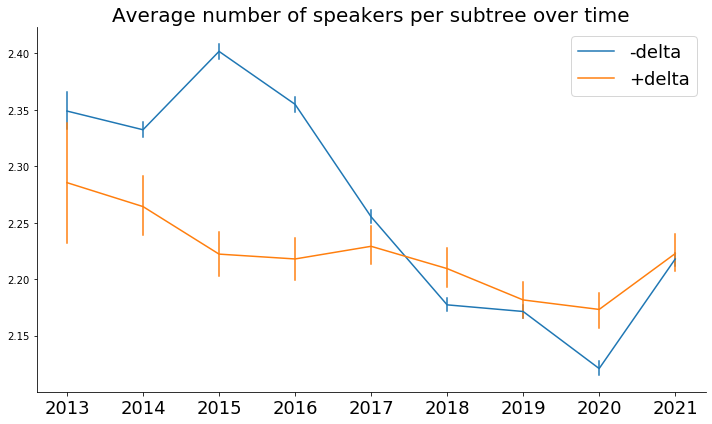

In [127]:
fig, ax = plt.subplots(figsize=(10,6))
sns.lineplot(x='year',y='num_speakers',hue='outcome',data=to_plot_df,
             err_style="bars",estimator='mean',ax=ax)
ax.set_xlabel('')
ax.set_ylabel('')
ax.set_xticklabels(range(2012,2022),fontsize=18)
ax.set_title('Average number of speakers per subtree over time',fontsize=20)
ax.legend(bbox_to_anchor=(1,1), title="", fontsize=18)
sns.despine()
plt.tight_layout()
plt.savefig('figs/mean_speakers_per_subtree_over_time.png',dpi=200)

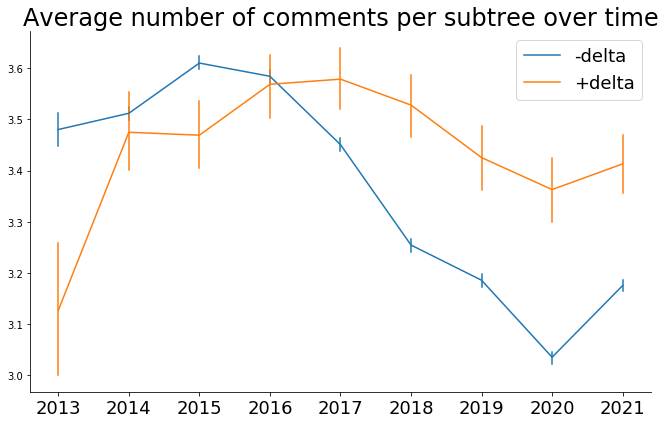

In [130]:
fig, ax = plt.subplots(figsize=(10,6))
sns.lineplot(x='year',y='num_comments',hue='outcome',data=to_plot_df,
             err_style="bars",estimator='mean',ax=ax)
ax.set_xlabel('')
ax.set_ylabel('')
ax.set_xticklabels(range(2012,2022),fontsize=18)
ax.set_title('Average number of comments per subtree over time',fontsize=24)
ax.legend(bbox_to_anchor=(1,1), title="", fontsize=18)
sns.despine()
plt.tight_layout()
plt.savefig('figs/mean_comments_per_subtree_over_time.png',dpi=200)

In [134]:
subtrees_per_post = to_plot_df.groupby(by='conversation_id').sum()
subtrees_per_post['post_year'] = [datetime.utcfromtimestamp(
    corp_to_analyze['full_cmv'].get_utterance(x).timestamp).year 
    for x in subtrees_per_post.index.values]
subtrees_per_post.head()

,count,+delta count,-delta count,num_speakers,num_comments,timestamp,year,month,post_year
conversation_id,,,,,,,,,
t3_16ra7x,7,0,7,11,13,9.518080e+09,14091,10,2013
t3_16ralh,2,0,2,4,6,2.716883e+09,4026,2,2013
t3_16rve8,10,0,10,19,26,1.358481e+10,20130,10,2013
t3_16rzx1,5,0,5,7,10,6.793292e+09,10065,5,2013
t3_16s6jg,2,0,2,5,9,2.716939e+09,4026,2,2013


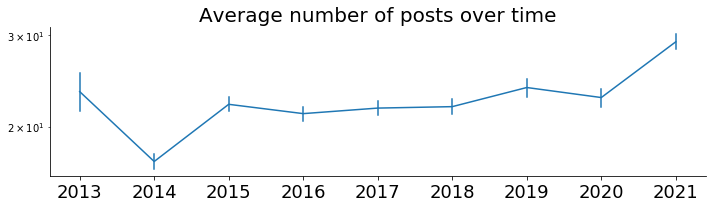

In [143]:
fig, ax = plt.subplots(figsize=(10,3))
sns.lineplot(x='post_year',y='count',data=subtrees_per_post,
             err_style="bars",estimator='mean',ax=ax)
ax.set_yscale('log')
ax.set_xlabel('')
ax.set_ylabel('')
ax.set_xticklabels(range(2012,2022),fontsize=18)
ax.set_title('Average number of posts over time',fontsize=22)
sns.despine()
plt.tight_layout()
plt.savefig('figs/mean_posts_over_time.png',dpi=200)

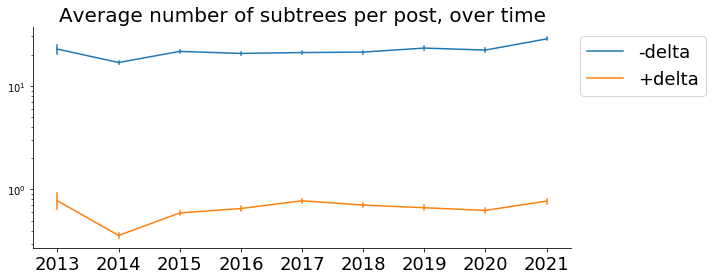

In [144]:
fig, ax = plt.subplots(figsize=(10,4))
sns.lineplot(x='post_year',y='-delta count',data=subtrees_per_post,
             err_style="bars",estimator='mean',ax=ax,label='-delta')
sns.lineplot(x='post_year',y='+delta count',data=subtrees_per_post,
             err_style="bars",estimator='mean',ax=ax,label='+delta')
ax.set_yscale('log')
ax.set_xlabel('')
ax.set_ylabel('')
ax.set_xticklabels(range(2012,2022),fontsize=18)
ax.set_title('Average number of subtrees per post, over time',fontsize=20)
ax.legend(bbox_to_anchor=(1,1), title="", fontsize=18)
sns.despine()
plt.tight_layout()
plt.savefig('figs/mean_subtrees_per_post_over_time.png',dpi=200)

# Subsampling

Potential filters:
* -delta sub-trees with too much elapsed time, as OP may have never seen it (separate label in meta dict)
* OP comments within sub-trees (another separate label in meta dict)

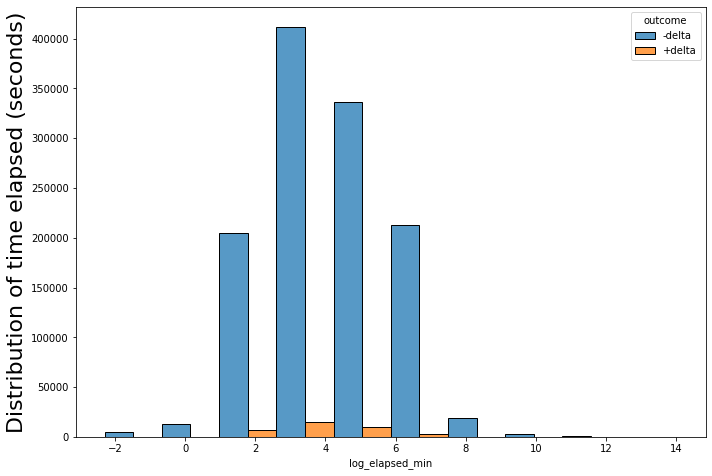

In [49]:
# def get_rel_timestamp_comment(corp,utt):
#     """
#     Returns the time elapsed in seconds between a comment and the OG post
#     """
#     return utt.timestamp - corp.get_utterance(utt.conversation_id).timestamp

# def get_rel_timestamp_subtree(corp,outcome_utt):
#     """
#     Returns the time elapsed in seconds between the first comment of a subtree and the OG post
#     """
#     first_utt_in_subtree = corp.get_utterance(outcome_utt.meta['path_to_outcome'][0])
#     return first_utt_in_subtree.timestamp - corp.get_utterance(outcome_utt.conversation_id).timestamp

# # TO DO: visualize distribution of elapsed time between OG post for +delta vs. -delta subtrees
# to_plot_df = pd.DataFrame({
#     'outcome_utt_id': [utt.id for utt in corp_to_analyze['full_cmv'].iter_utterances()
#                        if (utt.id[:2] == 't1')
#                        and (utt.meta['outcome'] != -1)],
#     'outcome': [utt.meta['outcome'] for utt in corp_to_analyze['full_cmv'].iter_utterances()
#                        if (utt.id[:2] == 't1')
#                        and (utt.meta['outcome'] != -1)],
#     'elapsed_time': [get_rel_timestamp_subtree(corp_to_analyze['full_cmv'],utt) 
#                        for utt in corp_to_analyze['full_cmv'].iter_utterances()
#                        if (utt.id[:2] == 't1')
#                        and (utt.meta['outcome'] != -1)]
# })
to_plot_df['log_elapsed_min'] = to_plot_df['elapsed_time'].apply(lambda x: np.log(x/60+0.1))

fig, ax = plt.subplots(figsize=(10,7))
sns.histplot(x='log_elapsed_min',bins=10,data=to_plot_df,hue='outcome',ax=ax,multiple='dodge')
ax.set_ylabel("Distribution of time elapsed (seconds)",fontsize=22)
plt.tight_layout()
plt.savefig(os.path.join('figs','time_elapsed_plus_minus_delta_subtrees.png'),dpi=200)

# [OLD] Find climate-change related conversations

* 1. Use high-precision keywords to retrieve posts w/ these keywords in the title.
* 2. Then manually check for complete confidence.
* 3. Then train tf-idf classifier on text of these documents to increase size of data.

In [6]:
import re
def remove_special_chars(s):
    return re.sub('[^A-Za-z]+', ' ', s)

def contains_keyword(s,keyword_set,ignore_case=True):
    if ignore_case:
        s = s.lower()
    pat = re.compile(r'\b(' + (r'|'.join(keyword_set)) + r')\b')
    #print(set(pat.findall(remove_special_chars(s))).intersection(keyword_set))
    return len(set(pat.findall(s)).intersection(keyword_set)) > 0

with open('../1_data_collection/keywords_high_precision.txt','r') as f:
    HI_PREC_CLIMATE_KEYWORDS = f.read().splitlines()
HI_PREC_CLIMATE_KEYWORDS.append('AGW')
#print(CLIMATE_KEYWORDS)

def get_op(corpus,convo_idx):
    return corpus.get_conversation(convo_idx)

def get_op_title(op):
    return op.meta['title']

In [31]:
# # Retrieval using high precision keywords
# climate_convo_idxs = []
# for convo in tqdm(corp_to_analyze['full_cmv'].iter_conversations()):
#     op_idx = convo.id
#     op = get_op(corp_to_analyze['full_cmv'],op_idx)
#     op_title = get_op_title(op)
#     if contains_keyword(op_title, set(HI_PREC_CLIMATE_KEYWORDS)):
#         climate_convo_idxs.append(op_idx)
# print(f'Found {len(climate_convo_idxs)} conversations with a high precision climate keyword in the post title.')

52863it [00:00, 65358.21it/s]

Found 423 conversations with a high precision climate keyword in the post title.


In [37]:
# # Manual check
# to_write = pd.DataFrame({
#     'id': climate_convo_idxs,
#     'title': [corp_to_analyze['full_cmv'].get_conversation(idx).meta['title']
#               for idx in climate_convo_idxs],
#     'text': [corp_to_analyze['full_cmv'].get_conversation(idx).meta['selftext_html']
#               for idx in climate_convo_idxs],
# })
# to_write.to_csv('full_cmv_high_prec_climate_kw_in_title.tsv',sep='\t',header=True,index=False)
# del to_write

In [5]:
# import pandas as pd
# manual_checked = pd.read_csv('full_cmv_high_prec_climate_kw_in_title_manual_checked.tsv',sep='\t')
# manual_checked = manual_checked.append(pd.read_csv('tf_idf_predicted_true_manual_checked.tsv',sep='\t'),
#                      ignore_index=True)
manual_checked = pd.read_csv('is_cc_related_gold_manual_checked.tsv',sep='\t')
manual_checked['is_true'] = manual_checked['is_true'].apply(
    lambda x: {'f':'false','m':'meta','d':'doom','r':'renewables/energy','v':'vegetarianism',
              'p':'overpopulation','g':'government/politics','c':'conservation','e':'economy',
              'l':'lifestyle','foo':'food (non-vegetarianism)','a':'adaptation',
              'mor':'ethics/morality','gm':'government/politics'}[x]
                if not pd.isnull(x) else 'other')
manual_checked['label'] = manual_checked['label'].apply(lambda x: {'s':'skeptic','st':'indifferent'}[x] 
                                                       if x in {'s','st'} else 'other')
gold_df = manual_checked.loc[manual_checked['is_true']!='false']

climate_convo_idxs_gold = gold_df['id'].values
print(f'Found {len(climate_convo_idxs_gold)} conversations which are manually checked to be true climate convos.')

Found 422 conversations which are manually checked to be true climate convos.


In [14]:
gold_df['is_true'].value_counts()

other                       103
meta                         51
doom                         48
renewables/energy            40
vegetarianism                39
overpopulation               37
government/politics          34
conservation                 23
economy                      22
lifestyle                    17
food (non-vegetarianism)      3
adaptation                    3
ethics/morality               2
Name: is_true, dtype: int64

In [15]:
gold_df['label'].value_counts()

other          321
skeptic         81
indifferent     20
Name: label, dtype: int64

In [17]:
gold_df.loc[(gold_df['is_true']=='vegetarianism') & (gold_df['label']=='skeptic')]['title'].values

array(['I believe that it is not morally obligatory to be a vegetarian. CMV.',
       'CMV: I think it makes no difference if I become a vegetarian.',
       'CMV: A diet can include meat and be as environmentally friendly as a vegan diet.',
       'CMV: Veganism isn\'t "better" than vegetarianism',
       'CMV: Veganism is ineffective at changing majority of what it aims to change',
       'CMV: Make me vegan/vegetarian/pescitarian',
       'I need reasons to become vegetarian, and ways to do so without making my life too uncomfortable or hard. CMV.',
       "CMV: Climate veganism is flawed and therefore shouldn't be used as an argument for veganism.",
       'CMV: Diets that include meat are superior to a vegetarian diet',
       "I think being vegan/vegetarian for a cause doesn't make sense. CMV"],
      dtype=object)

In [17]:
# Inspect examples of false positives
#manual_checked.loc[manual_checked['is_true'].apply(lambda x: x=='f')]

In [6]:
# Add meta field for whether utterance belongs to climate change-related conversation
c_id2other_cc_label = dict(zip(gold_df['id'].values,gold_df['is_true'].values))
for convo in tqdm(corp_to_analyze[corp_name].iter_conversations()):
    if convo.id not in c_id2other_cc_label:
        c_id2other_cc_label[convo.id] = 'non-cc'

for utt in tqdm(corp_to_analyze[corp_name].iter_utterances()):
    utt.meta['is_cc_related_gold'] = utt.conversation_id in climate_convo_idxs_gold
    utt.meta['other_cc_label'] = c_id2other_cc_label[utt.conversation_id]
for convo in tqdm(corp_to_analyze[corp_name].iter_conversations()):
    convo.meta['other_cc_label'] = c_id2other_cc_label[convo.id]
print(Counter([utt.meta['is_cc_related_gold'] for utt in tqdm(corp_to_analyze[corp_name].iter_utterances())]))
print(Counter([utt.meta['other_cc_label'] for utt in tqdm(corp_to_analyze[corp_name].iter_utterances())]))

84258it [00:00, 371741.68it/s]
3243830it [03:24, 15843.21it/s]
84258it [00:00, 100604.41it/s]
3243830it [00:09, 344119.52it/s]


Counter({False: 3214504, True: 29326})


3243830it [00:07, 444332.83it/s]


Counter({'non-cc': 3214504, 'other': 5677, 'renewables/energy': 4159, 'meta': 4084, 'vegetarianism': 3685, 'government/politics': 3009, 'overpopulation': 2852, 'doom': 2263, 'conservation': 1637, 'economy': 885, 'lifestyle': 539, 'food (non-vegetarianism)': 267, 'ethics/morality': 167, 'adaptation': 102})


In [153]:
# Create train/eval splits
pos = [corp_to_analyze['full_cmv'].get_conversation(idx) for idx in climate_convo_idxs_gold]
neg = []
while len(neg) < len(pos):
    ex = corp_to_analyze['full_cmv'].random_conversation() 
    try:
        ex_text = corp_to_analyze['full_cmv'].get_utterance(ex.id).text
    except KeyError:
        ex_text = ''
    if len(ex_text) > 0:
        neg.append(ex)
        
split_ids = {'train':np.random.choice([c.id for c in pos+neg],replace=False,size=int(0.8*(len(pos)+len(neg))))}
split_ids['eval'] = [c.id for c in pos+neg if c.id not in set(split_ids['train'])]

split_dfs = {split: pd.DataFrame({
                            'id':split_ids[split],
                            'title':[corp_to_analyze['full_cmv'].get_conversation(idx).meta['title']
                                     for idx in split_ids[split]],
                            'text':[corp_to_analyze['full_cmv'].get_utterance(idx).text
                                     for idx in split_ids[split]],
                            'label':[1 if idx in climate_convo_idxs_gold else 0
                                    for idx in split_ids[split]]
                        }) for split in split_ids
            }

assert set(split_dfs['train']['id'].values).intersection(set(split_dfs['eval']['id'].values)) == set()

In [158]:
# Train tf-idf classifier 
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.linear_model import SGDClassifier
from sklearn.pipeline import Pipeline
import nltk
from nltk.stem.snowball import SnowballStemmer
nltk.download('stopwords')

stemmer = SnowballStemmer("english", ignore_stopwords=True)
class StemmedCountVectorizer(CountVectorizer):
    def build_analyzer(self):
        analyzer = super(StemmedCountVectorizer, self).build_analyzer()
        return lambda doc: ([stemmer.stem(w) for w in analyzer(doc)])
stemmed_count_vect = StemmedCountVectorizer(stop_words='english',ngram_range=(1,2))

text_clf_svm = Pipeline([('vect', stemmed_count_vect),
                     ('tfidf', TfidfTransformer()),
                     ('clf-svm', SGDClassifier(loss='hinge', penalty='l2',
                                           alpha=1e-3, n_iter_no_change=5, random_state=42)),
])
_ = text_clf_svm.fit(split_dfs['train']['text'].values, split_dfs['train']['label'].values)
predicted_svm = text_clf_svm.predict(split_dfs['eval']['text'].values)
np.mean(predicted_svm == split_dfs['eval']['label'].values)

[nltk_data] Downloading package stopwords to
[nltk_data]     /sailhome/yiweil/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


0.9392857142857143

In [155]:
preds_df = pd.DataFrame({
    'text':split_dfs['eval']['text'].values,
    'true':split_dfs['eval']['label'].values,
    'predicted':predicted_svm
})
preds_df.loc[preds_df['true']!=preds_df['predicted']]

,text,true,predicted
56,"Apparently Tucker when off on a long monologue and among cable news junkies it was a shot heard 'round the world. Surprisingly, on the list of the ills of our nation (the USA) is legal Cannabis. This is a bit of what he had to say: \n\n ""If you really loved your fellow Americans, as our leaders should, if it would break your heart to see them high all the time. Which they are. A huge number of our kids, especially our boys, are smoking weed constantly. You may not realize that, because new technology has made it odorless. But it’s everywhere.\n\n Once our leaders understood they could get rich from marijuana, marijuana became ubiquitous. In many places, tax-hungry politicians have legalized or decriminalized it. Former Speaker of the House John Boehner now lobbies for the marijuana industry. His fellow Republicans seem fine with that. “Oh, but it’s better for you than alcohol,” they tell us. \n\n Who cares? Talk about missing the point. Try having dinner with a 19-year-old who’s been smoking weed. The life is gone. Passive, flat, trapped in their own heads. Do you want that for your kids? Of course not. Then why are our leaders pushing it on us? You know the reason. ""\n\nI think having dinner with most 19 year olds is awful anyway, I almost wish they would smoke weed so I don't have to listen to their idiotic ideas on the world. I really doubt the reason Cannabis is legal is because John Boehner might get more money. I also doubt that kids are smoking weed constantly, in fact, it seems rather stable. \n\nBy all means though, I might be off base, change my view. \n\n&#x200B;",1,0
64,"On a macroscopic level the universe appears deterministic, e.g. if you throw a ball and know the initial conditions you can predict where it will land.\n\nAlthough I do not know the specifics, I am aware that there are some events on the quantum level which are truly random which would mean that determinism is not valid. However, randomness is not equivalent to choice. For example, if you roll a die to decide what to do you are not making the decision, hence no will is exerted.\n\nFrom this premise, I would conclude there is no free will as everything which happens is the culmination of the causal chain started with the creation of the universe, with some events that occur being random in nature.\n\nAs such, while I do not believe that if we had perfect knowledge we could predict the future, there also does not seem to be any evidence for free will's existence in our current scientific understanding of the universe.\n\nTherefore, any belief in in free will is unfounded and entirely faith based. \n\n&#x200B;",1,0
72,"Let's assume that we will never reach consensus on the reality of AGW. We do know, however, that oil and coal are non-renewable resources. It is therefore wise to preserve them for our children. Fossil fuels are also direct pollutants by way of ocean acidification and particulate matter.\n\nA carbon tax would encourage conservation of a limited resource, and discourage pollution. Just in case AGW is real, we would also have hedged our bets there.\n \nA wealth tax is equally virtuous because it discourages the pooling of money and encourages it to be pumped through the economy. It whittles away at inheritance and encourages investment (you need your investments to ""outrun"" the wealth tax).\n\nConversely, income, payroll, capital gains and sales taxes all act as brakes on the economy. All of them ""punish"" things we want people to do: make money, get paid, invest money and buy things.\n\nFor example, in the economy I describe, a small time musician would see virtually no taxes except those embedded in the fossil-fuel-based products that she buys. She would pay no income tax or sales tax. Once she went on tour and started using significant amounts of electricity on lights and sound, the event organizers would have to build those costs into the ticket prices. This means that the tour might be a bit smaller and 

In [156]:
from sklearn.model_selection import GridSearchCV
parameters_svm = {'vect__ngram_range': [(1, 1), (1, 2)],
               'tfidf__use_idf': (True, False),
               'clf-svm__alpha': (1e-2, 1e-3),
}
gs_clf_svm = GridSearchCV(text_clf_svm, parameters_svm, n_jobs=-1)
gs_clf_svm = gs_clf_svm.fit(split_dfs['train']['text'].values, split_dfs['train']['label'].values)
print(gs_clf_svm.best_score_)
print(gs_clf_svm.best_params_)

/u/nlp/anaconda/main/anaconda3/envs/yiwei-climate/lib/python3.6/site-packages/sklearn/model_selection/_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)


0.9451219512195121
{'clf-svm__alpha': 0.001, 'tfidf__use_idf': True, 'vect__ngram_range': (1, 2)}


In [159]:
# Apply model to unlabeled text
unlabeled_ids = [convo.id for convo in corp_to_analyze['full_cmv'].iter_conversations()
                 if convo.id not in climate_convo_idxs_gold 
                 and not is_removed_convo(corp_to_analyze['full_cmv'],convo.id)]
df_ids = []
for idx in unlabeled_ids:
    try:
        corp_to_analyze['full_cmv'].get_utterance(idx)
        df_ids.append(idx)
    except KeyError:
        pass
print(len(unlabeled_ids),len(df_ids))
unlabeled_df = pd.DataFrame({
                            'id':df_ids,
                            'title':[corp_to_analyze['full_cmv'].get_conversation(idx).meta['title']
                                     for idx in df_ids],
                            'text':[corp_to_analyze['full_cmv'].get_utterance(idx).text
                                     for idx in df_ids]
                        })
predicted_unlabeled_text = text_clf_svm.predict(unlabeled_df['text'].values)

25563 25502


In [160]:
unlabeled_df['label'] = predicted_unlabeled_text
unlabeled_df['label'].value_counts()

0    23369
1     2133
Name: label, dtype: int64

In [161]:
unlabeled_df.loc[unlabeled_df['label']==1].to_csv('tf_idf_predicted_true.tsv',sep='\t',header=True,index=False)

# [OLD] Subsample for even distributions

Subsample from comments not receiving deltas by:
   * **removing comments from OP(?)**
   * limiting comment depth to odd depths <= 7
   * matching comment time (fixed time window)
   * matching comment order (number of comments before)
   * matching comment length
   * try to represent the same number of different voices/people

In [7]:
# Checks if comment is not written by mod/bot, and not removed/delted
def is_valid(utt):
    return not utt.meta['written_by_bot'] \
    and not utt.text == '[deleted]' \
    and not utt.text == '[removed]'

def filter_random_for_matched_mean(target_mean,epsilon,greater_than,dat,field,n=50000):
    dat_ = dat.copy()
    curr_mean = dat_[field].mean() 
    while abs(curr_mean - target_mean) > epsilon:
        # randomly select a datapoint greater than target_mean to remove
        if greater_than:
            sample_dat_ = dat_.loc[dat_[field] > target_mean]
        else:
            sample_dat_ = dat_.loc[dat_[field] < target_mean]
        rand = sample_dat_.sample(n=n, replace=False)
        dat_ = dat_.drop(rand.index, axis=0)
        curr_mean = dat_[field].mean() 
        print(f'Curr mean of {field}: {curr_mean}')
    
    return dat_

# Number of comments w/ and w/o deltas
total_delta_counts = Counter([utt.meta['is_awarded_delta'] 
                              for utt in corp_to_analyze['full_cmv'].iter_utterances()
                              if is_valid(utt)])
print('Within full comments, found {} comments awarded deltas and {} comments without'.format(
    total_delta_counts[True], total_delta_counts[False]))

cc_delta_counts = Counter([utt.meta['is_awarded_delta'] 
                           for utt in corp_to_analyze['full_cmv'].iter_utterances()
                           if utt.meta['is_cc_related_gold']
                           and is_valid(utt)])
print('Within climate comments, found {} comments awarded deltas and {} comments without'.format(
    cc_delta_counts[True], cc_delta_counts[False]))

Within full comments, found 31674 comments awarded deltas and 2865046 comments without
Within climate comments, found 378 comments awarded deltas and 26877 comments without


## Depth

84258it [00:39, 2153.27it/s] 
3243830it [00:31, 102918.61it/s]


Found 30436 total comments w/ deltas and 1530576 comments w/o (excluding bots and mods, deleted) with odd depth <= 7.
Found 361 CC comments w/ deltas and 13639 comments w/o (excluding bots and mods, deleted) with odd depth <= 7.


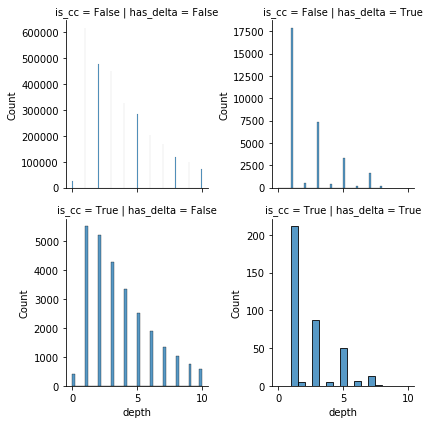

In [8]:
# initialize depth dict: start by getting convo; then get root to leaf paths
# for each path:
#    index of utt in path is its depth
depth_per_utt = {}
for convo in tqdm(corp_to_analyze['full_cmv'].iter_conversations()):
    paths = convo.get_root_to_leaf_paths()
    for path in paths:
        for i in range(len(path)):
            utt_id = path[i].id
            if utt_id not in depth_per_utt:
                depth_per_utt[utt_id] = i
                
for utt in tqdm(corp_to_analyze['full_cmv'].iter_utterances()):
    utt.meta['depth'] = depth_per_utt[utt.id]
    
# Distribution of comment depths for comments on cc-related posts, not written by bots/mods, awarded deltas
utt_zip = [(utt.meta['depth'],utt.meta['is_awarded_delta'],utt.meta['is_cc_related_gold']) 
           for utt in corp_to_analyze['full_cmv'].iter_utterances() 
           if is_valid(utt)]

to_plot_df = pd.DataFrame({
    'depth':[item[0] for item in utt_zip],
    'log_depth':[np.log(item[0]+1) for item in utt_zip],
    'has_delta':[item[1] for item in utt_zip],
    'is_cc':[item[2] for item in utt_zip]})

g = sns.FacetGrid(to_plot_df, col="has_delta", row='is_cc', sharey=False)
g.map(sns.histplot, "depth")

MAX_DEPTH = 7
def is_valid_depth(utt,max_depth=MAX_DEPTH):
    return utt.meta['depth'] <= max_depth and utt.meta['depth'] % 2 == 1

depth_filtered_utts = [
    utt for utt in corp_to_analyze['full_cmv'].iter_utterances()
    if is_valid(utt)
    and is_valid_depth(utt)]
cc_depth_filtered_utts = [utt for utt in depth_filtered_utts if utt.meta['is_cc_related_gold']]
delta_counts_depth_filtered = Counter([utt.meta['is_awarded_delta'] for utt in depth_filtered_utts])
cc_delta_counts_depth_filtered = Counter([utt.meta['is_awarded_delta'] for utt in cc_depth_filtered_utts])
print('Found {} total comments w/ deltas and {} comments w/o (excluding bots and mods, deleted) \
with odd depth <= 7.'.format(delta_counts_depth_filtered[True], delta_counts_depth_filtered[False]))
print('Found {} CC comments w/ deltas and {} comments w/o (excluding bots and mods, deleted) \
with odd depth <= 7.'.format(cc_delta_counts_depth_filtered[True], cc_delta_counts_depth_filtered[False]))

## Time difference

3243830it [00:35, 91944.68it/s] 


Matching -delta sample to max time diff of +delta sample: 12.438397321042864
Matching -delta sample to within epsilon=0.005 of mean time diff of +delta sample: 4.502540583404912
Curr mean of log_time_diff_mins: 5.360090087267177
Curr mean of log_time_diff_mins: 5.345606190765934
Curr mean of log_time_diff_mins: 5.330537980796741
Curr mean of log_time_diff_mins: 5.314829032002288
Curr mean of log_time_diff_mins: 5.298459092859366
Curr mean of log_time_diff_mins: 5.281746964104508
Curr mean of log_time_diff_mins: 5.264162369879704
Curr mean of log_time_diff_mins: 5.245732416830133
Curr mean of log_time_diff_mins: 5.22638145096718
Curr mean of log_time_diff_mins: 5.2063465029960945
Curr mean of log_time_diff_mins: 5.185622878801651
Curr mean of log_time_diff_mins: 5.16394347234059
Curr mean of log_time_diff_mins: 5.141284182422304
Curr mean of log_time_diff_mins: 5.117516195685187
Curr mean of log_time_diff_mins: 5.092757009113072
Curr mean of log_time_diff_mins: 5.067032832471578
Curr me

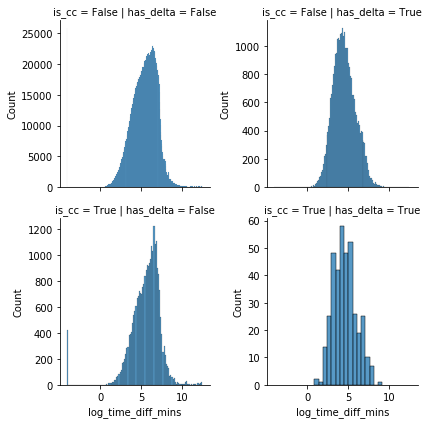

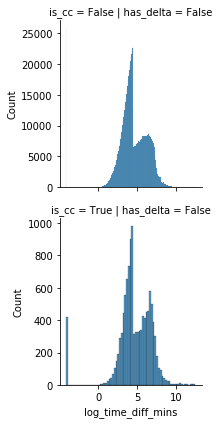

In [9]:
def get_rel_timestamp(corp,utt):
    return utt.timestamp - corp.get_utterance(utt.conversation_id).timestamp

for utt in tqdm(corp_to_analyze['full_cmv'].iter_utterances()):
    utt.meta['time_diff'] = get_rel_timestamp(corp_to_analyze['full_cmv'],utt)
    
# Distribution of comment depths for comments on cc-related posts, not written by bots/mods, awarded deltas
utt_zip = [(utt.id,utt.meta['time_diff'],utt.meta['is_awarded_delta'],utt.meta['is_cc_related_gold']) 
           for utt in corp_to_analyze['full_cmv'].iter_utterances() 
           if is_valid(utt)]

to_plot_df = pd.DataFrame({
    'id':[item[0] for item in utt_zip],
    'time_diff_secs':[item[1] for item in utt_zip],
    'time_diff_mins':[item[1]/60 for item in utt_zip],
    'time_diff_hrs':[item[1]/(60*60) for item in utt_zip],
    'log_time_diff_mins':[np.log((item[1]+1)/60) for item in utt_zip],
    'log_time_diff_hrs':[np.log((item[1]+1)/3600) for item in utt_zip],
    'has_delta':[item[2] for item in utt_zip],
    'is_cc':[item[3] for item in utt_zip]})

g = sns.FacetGrid(to_plot_df, col="has_delta", row="is_cc", sharey=False)#,  row="sex")
g.map(sns.histplot, "log_time_diff_mins")

MAX_TIME_DIFF = to_plot_df.loc[to_plot_df['has_delta']]['log_time_diff_mins'].max()
print(f'Matching -delta sample to max time diff of +delta sample: {MAX_TIME_DIFF}')
max_time_diff_matched = to_plot_df.loc[(~to_plot_df['has_delta']) & 
                                       (to_plot_df['log_time_diff_mins'] <= MAX_TIME_DIFF)]

target_mean_time_diff = to_plot_df.loc[to_plot_df['has_delta']]['log_time_diff_mins'].mean()
epsilon = 0.005
print(f'Matching -delta sample to within epsilon={epsilon} of mean time diff of +delta sample:', 
      target_mean_time_diff)
mean_max_time_diff_matched = filter_random_for_matched_mean(target_mean_time_diff,0.005,True,
                                                            max_time_diff_matched,
                                                            'log_time_diff_mins')

g = sns.FacetGrid(mean_max_time_diff_matched, col="has_delta", row="is_cc", sharey=False)#,  row="sex")
g.map(sns.histplot, "log_time_diff_mins")

matched_no_deltas_ids = set(mean_max_time_diff_matched['id'].values)
time_diff_filtered_utts = [
    utt for utt in corp_to_analyze['full_cmv'].iter_utterances()
    if is_valid(utt)
    and (utt.meta['is_awarded_delta'] or (
    not utt.meta['is_awarded_delta'] and utt.id in matched_no_deltas_ids))]
cc_time_diff_filtered_utts = [utt for utt in time_diff_filtered_utts if utt.meta['is_cc_related_gold']]
delta_counts_time_diff_filtered = Counter([utt.meta['is_awarded_delta'] for utt in time_diff_filtered_utts])
cc_delta_counts_time_diff_filtered = Counter([utt.meta['is_awarded_delta'] for utt in cc_time_diff_filtered_utts])
print('Found {} total comments w/ deltas and {} matched-mean comments w/o (excluding bots and mods, deleted) \
with time diff. <= {:0.2f} log minutes.'.format(delta_counts_time_diff_filtered[True], 
                                                delta_counts_time_diff_filtered[False],
                                                MAX_TIME_DIFF))
print('Found {} CC comments w/ deltas and {} matched-mean comments w/o (excluding bots and mods, deleted) \
with time diff. <= {:0.2f} log minutes.'.format(cc_delta_counts_time_diff_filtered[True], 
                                                cc_delta_counts_time_diff_filtered[False],
                                                MAX_TIME_DIFF))

## Order

3243830it [28:51, 1873.37it/s]


Matching -delta sample to max comment order of +delta sample: 481
Matching -delta sample to within epsilon=1 of mean comment order of +delta sample: 32.38321651827998
Curr mean of order: 82.96713972309031
Curr mean of order: 82.09895141235087
Curr mean of order: 81.19154796899463
Curr mean of order: 80.2694016076079
Curr mean of order: 79.2973712526824
Curr mean of order: 78.30195924373551
Curr mean of order: 77.27773445333214
Curr mean of order: 76.19789829726842
Curr mean of order: 75.07539314873685
Curr mean of order: 73.9119092672392
Curr mean of order: 72.68600410835262
Curr mean of order: 71.4089843487666
Curr mean of order: 70.09266645461872
Curr mean of order: 68.67544754952536
Curr mean of order: 67.1930999140695
Curr mean of order: 65.68119055742739
Curr mean of order: 64.06745173185202
Curr mean of order: 62.388822392091825
Curr mean of order: 60.60605507866888
Curr mean of order: 58.74135958302743
Curr mean of order: 56.753723523935996
Curr mean of order: 54.655102600979056

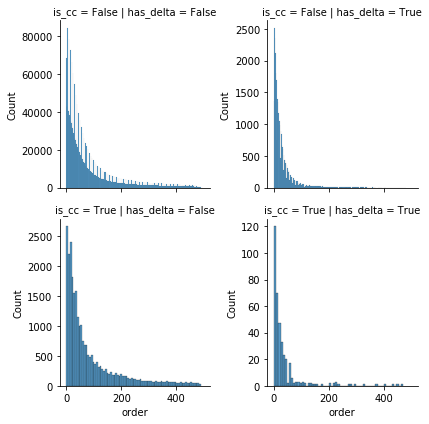

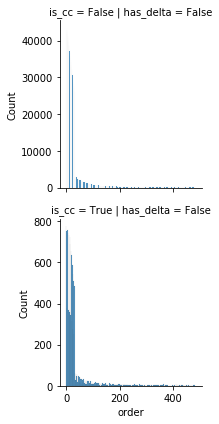

In [10]:
def get_utt_order(corp,convo_id, utt_id):
    convo = corp.get_conversation(convo_id)
    in_order_utt_ids = [utt.id for utt in convo.get_chronological_utterance_list()]
    return in_order_utt_ids.index(utt_id)

for utt in tqdm(corp_to_analyze['full_cmv'].iter_utterances()):
    utt.meta['order'] = get_utt_order(corp_to_analyze['full_cmv'], utt.conversation_id, utt.id)
    
# Distribution of comment depths for comments on cc-related posts, not written by bots/mods, awarded deltas
utt_zip = [(utt.id,utt.meta['order'],utt.meta['is_awarded_delta'],utt.meta['is_cc_related_gold']) 
           for utt in corp_to_analyze['full_cmv'].iter_utterances() 
           if is_valid(utt)]

to_plot_df = pd.DataFrame({
    'id':[item[0] for item in utt_zip],
    'order':[item[1] for item in utt_zip],
    'log_order':[np.log(item[1]+1) for item in utt_zip],
    'has_delta':[item[2] for item in utt_zip],
    'to_keep':[item[2] <= 200 for item in utt_zip],
    'is_cc':[item[3] for item in utt_zip]})

g = sns.FacetGrid(to_plot_df, col="has_delta", sharey=False, row="is_cc")#, palette=['grey','orange'])
g.map(sns.histplot, "order")
#g.savefig('figs/delta_v_no_delta_order.png',dpi=200)

MAX_ORDER = to_plot_df.loc[to_plot_df['has_delta']]['order'].max()
print(f'Matching -delta sample to max comment order of +delta sample: {MAX_ORDER}')
max_order_matched = to_plot_df.loc[(~to_plot_df['has_delta']) & 
                                   (to_plot_df['order'] <= MAX_ORDER)]

target_mean_order = to_plot_df.loc[to_plot_df['has_delta']]['order'].mean()
epsilon = 1
print(f'Matching -delta sample to within epsilon={epsilon} of mean comment order of +delta sample:', 
      target_mean_order)
mean_max_order_matched = filter_random_for_matched_mean(target_mean_order,epsilon,True,
                                                            max_order_matched,
                                                            'order')
#target_mean,epsilon,greater_than,dat,field

g = sns.FacetGrid(mean_max_order_matched, col="has_delta", row="is_cc", sharey=False)#,  row="sex")
g.map(sns.histplot, "order")

matched_no_deltas_ids = set(mean_max_order_matched['id'].values)
order_filtered_utts = [
    utt for utt in corp_to_analyze['full_cmv'].iter_utterances()
    if is_valid(utt)
    and (utt.meta['is_awarded_delta'] or (
    not utt.meta['is_awarded_delta'] and utt.id in matched_no_deltas_ids))]
cc_order_filtered_utts = [utt for utt in order_filtered_utts if utt.meta['is_cc_related_gold']]
delta_counts_order_filtered = Counter([utt.meta['is_awarded_delta'] for utt in order_filtered_utts])
cc_delta_counts_order_filtered = Counter([utt.meta['is_awarded_delta'] for utt in cc_order_filtered_utts])
print('Found {} total comments w/ deltas and {} matched-mean comments w/o (excluding bots and mods, deleted) \
with order <= {:0.2f} comments.'.format(delta_counts_order_filtered[True], 
                                                delta_counts_order_filtered[False],
                                                MAX_ORDER))
print('Found {} CC comments w/ deltas and {} matched-mean comments w/o (excluding bots and mods, deleted) \
with order <= {:0.2f} comments.'.format(cc_delta_counts_order_filtered[True], 
                                                cc_delta_counts_order_filtered[False],
                                                MAX_ORDER))

## Length

Matching -delta sample to min log len of +delta sample: 2
Matching -delta sample to within epsilon=0.05 of mean log len of +delta sample: 4.827211353508079
Curr mean of log_len: 4.032936633940786
Curr mean of log_len: 4.0397920817757385
Curr mean of log_len: 4.046923742915588
Curr mean of log_len: 4.054363622106029
Curr mean of log_len: 4.062155804638746
Curr mean of log_len: 4.0702130454263905
Curr mean of log_len: 4.0786097180897345
Curr mean of log_len: 4.08723604511754
Curr mean of log_len: 4.096263749397243
Curr mean of log_len: 4.105782450667212
Curr mean of log_len: 4.115625308403872
Curr mean of log_len: 4.126043662111532
Curr mean of log_len: 4.136927206727823
Curr mean of log_len: 4.1483857494499965
Curr mean of log_len: 4.160290864566782
Curr mean of log_len: 4.172854491182018
Curr mean of log_len: 4.186054126094847
Curr mean of log_len: 4.200027483128353
Curr mean of log_len: 4.214707612088217
Curr mean of log_len: 4.230305582725713
Curr mean of log_len: 4.246860613623238
C

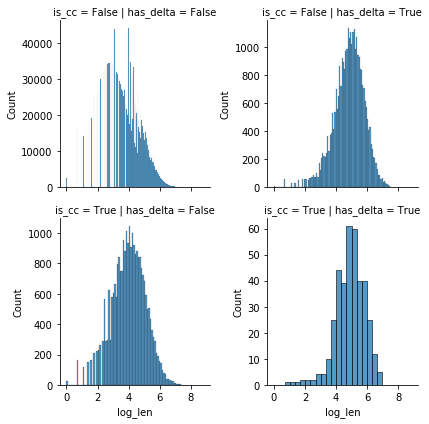

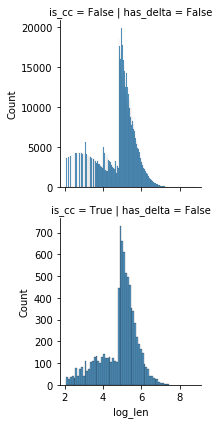

In [11]:
# Distribution of comment lengths for comments on cc-related posts, not written by bots/mods, awarded deltas
utt_zip = [(utt.id,len(utt.text.split()),utt.meta['is_awarded_delta'],utt.meta['is_cc_related_gold']) 
           for utt in corp_to_analyze['full_cmv'].iter_utterances() 
           if is_valid(utt)]

to_plot_df = pd.DataFrame({
    'id':[item[0] for item in utt_zip],
    'len':[item[1] for item in utt_zip],
    'log_len':[np.log(item[1]+1) for item in utt_zip],
    'has_delta':[item[2] for item in utt_zip],
    'to_keep':[np.log(item[1]+1)>=4 for item in utt_zip],
    'is_cc':[item[3] for item in utt_zip]})

g = sns.FacetGrid(to_plot_df, col="has_delta", row='is_cc', sharey=False)#,  row="sex")
g.map(sns.histplot, "log_len")
#g.savefig('figs/delta_v_no_delta_len.png',dpi=200)

MIN_LEN = 2#to_plot_df.loc[to_plot_df['has_delta']]['log_len'].min()
print(f'Matching -delta sample to min log len of +delta sample: {MIN_LEN}')
min_len_matched = to_plot_df.loc[(~to_plot_df['has_delta']) & 
                                 (to_plot_df['log_len'] >= MIN_LEN)]

target_mean_len = to_plot_df.loc[to_plot_df['has_delta']]['log_len'].mean()
epsilon = 0.05
print(f'Matching -delta sample to within epsilon={epsilon} of mean log len of +delta sample:', 
      target_mean_len)
mean_min_len_matched = filter_random_for_matched_mean(target_mean_len,epsilon,False,
                                                            min_len_matched,
                                                            'log_len')

g = sns.FacetGrid(mean_min_len_matched, col="has_delta", row="is_cc", sharey=False)#,  row="sex")
g.map(sns.histplot, "log_len")

matched_no_deltas_ids = set(mean_min_len_matched['id'].values)
len_filtered_utts = [
    utt for utt in corp_to_analyze['full_cmv'].iter_utterances()
    if is_valid(utt)
    and np.log(len(utt.text.split())+1) >= 4
    and (utt.meta['is_awarded_delta'] or (
    not utt.meta['is_awarded_delta'] and utt.id in matched_no_deltas_ids))]
cc_len_filtered_utts = [utt for utt in len_filtered_utts if utt.meta['is_cc_related_gold']]
delta_counts_len_filtered = Counter([utt.meta['is_awarded_delta'] for utt in len_filtered_utts])
cc_delta_counts_len_filtered = Counter([utt.meta['is_awarded_delta'] for utt in cc_len_filtered_utts])
print('Found {} total comments w/ deltas and {} matched-mean comments w/o (excluding bots and mods, deleted) \
with log len >= {:0.2f}.'.format(delta_counts_len_filtered[True], 
                             delta_counts_len_filtered[False],
                             MIN_LEN))
print('Found {} CC comments w/ deltas and {} matched-mean comments w/o (excluding bots and mods, deleted) \
with log len >= {:0.2f}.'.format(cc_delta_counts_len_filtered[True], 
                             cc_delta_counts_len_filtered[False],
                             MIN_LEN))

In [ ]:
to_plot_df.loc[to_plot_df['has_delta']].describe()

## Written by OP

In [12]:
# Finally, remove comments written by OP--these by design cannot get awarded deltas
non_OP_utt_ids = [utt.id for utt in corp_to_analyze['full_cmv'].iter_utterances()
                  if is_valid(utt) 
                  and utt.speaker.id != corp_to_analyze['full_cmv'].get_utterance(utt.conversation_id).speaker.id]
print(f"Found {len(non_OP_utt_ids)} valid comments not written by OP themselves.")

Found 2333405 valid comments not written by OP themselves.


## Aggregating all criteria

Put everything together:
* depth (<= max; odd)
* time diff. (<= max log minutes)
* order (<= max)
* len (>= min log)
* not written by OP

In [13]:
filtered_utts = {
    'depth': depth_filtered_utts,
    'time_diff': time_diff_filtered_utts,
    'order': order_filtered_utts,
    'len': len_filtered_utts,
    'non_OP': non_OP_utt_ids,}
for field in filtered_utts:
    print(field,len(filtered_utts[field]))
    
filtered_intersection_utt_ids = set([utt.id for utt in depth_filtered_utts]).intersection(
    set([utt.id for utt in time_diff_filtered_utts])
        ).intersection(
    set([utt.id for utt in order_filtered_utts])
        ).intersection(
    set([utt.id for utt in len_filtered_utts])
        ).intersection(
    set(non_OP_utt_ids)
        ).intersection(
    set([utt.id for utt in corp_to_analyze['full_cmv'].iter_utterances()
        if is_valid(utt)])
)

print(f'Found {len(filtered_intersection_utt_ids)} valid utterances meeting all criteria.\n')
filtered_intersection_utts = [corp_to_analyze['full_cmv'].get_utterance(utt_id)
                              for utt_id in filtered_intersection_utt_ids]
cc_filtered_intersection_utts = [utt for utt in filtered_intersection_utts 
                                 if utt.meta['is_cc_related_gold']]
delta_counts_filtered_utts = Counter([utt.meta['is_awarded_delta'] for utt in filtered_intersection_utts])
cc_delta_counts_filtered_utts = Counter([utt.meta['is_awarded_delta'] for utt in cc_filtered_intersection_utts])
print(f'Found {delta_counts_filtered_utts[True]} +delta comments and {delta_counts_filtered_utts[False]} \
-delta comments among above.')
print(f'Found {cc_delta_counts_filtered_utts[True]} +delta comments and {cc_delta_counts_filtered_utts[False]} \
-delta CC comments among above.')

depth 1561012
time_diff 1396558
order 1395010
len 702034
non_OP 2333405
Found 160528 valid utterances meeting all criteria.

Found 24240 +delta comments and 136288 -delta comments among above.
Found 310 +delta comments and 1239 -delta CC comments among above.


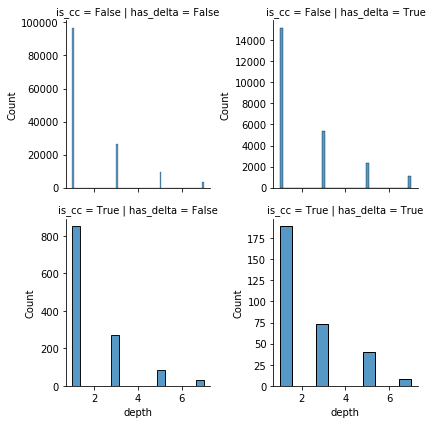

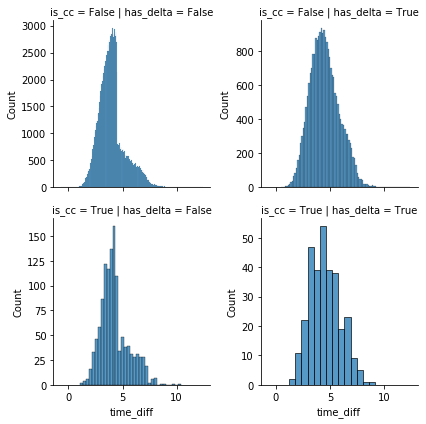

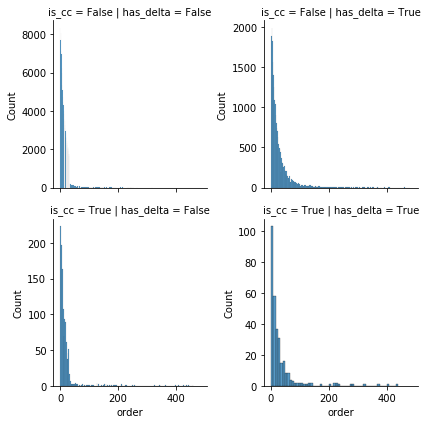

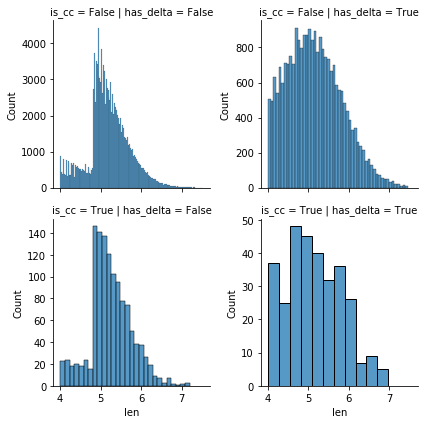

In [40]:
# Sanity check plotted distributions
utt_zip = [(utt.id,utt.meta['depth'],utt.meta['time_diff'],utt.meta['order'],
           len(utt.text.split()),utt.meta['is_awarded_delta'],utt.meta['is_cc_related_gold']) 
           for utt in filtered_intersection_utts]

to_plot_df = pd.DataFrame({
    'id':[item[0] for item in utt_zip],
    'depth':[item[1] for item in utt_zip],
    'time_diff':[np.log((item[2]+1)/60) for item in utt_zip],
    'order':[item[3] for item in utt_zip],
    'len':[np.log(item[4]+1) for item in utt_zip],
    'has_delta':[item[5] for item in utt_zip],
    'is_cc':[item[6] for item in utt_zip]})

for field in filtered_utts:
    if field != 'non_OP':
        g = sns.FacetGrid(to_plot_df, col="has_delta", row='is_cc', sharey=False)
        g.map(sns.histplot, field)

In [18]:
# all utterances, no OPs
print(Counter([x[:2] for x in filtered_intersection_utt_ids]))
print(Counter([utt.meta['written_by_bot'] or utt.text=='[removed]' or utt.text=='[deleted]' 
         for utt in filtered_intersection_utts]))
print(Counter([is_valid(utt)
         for utt in filtered_intersection_utts]))

Counter({'t1': 160491})
Counter({False: 160491})
Counter({True: 160491})


In [14]:
filtered_intersection_convo_ids = set([utt.conversation_id for utt in filtered_intersection_utts])
#filtered_intersection_convo_utts = []
print(f"Found {len(filtered_intersection_convo_ids)} conversations to which filtered comments belong.")
ids_for_subsample = set(filtered_intersection_utt_ids) | filtered_intersection_convo_ids
subsample = corp_to_analyze['full_cmv'].filter_utterances_by(lambda utt: utt.id in ids_for_subsample)
subsample.print_summary_stats()
print(Counter([utt.meta['is_cc_related_gold'] for utt in subsample.iter_utterances()]))
# print(Counter([utt.meta['is_generic'] for utt in subsample.iter_utterances()]))
# subsample.dump('subsampled_cmv_corpus','/u/scr/yiweil')

Found 44363 conversations to which filtered comments belong.
Number of Speakers: 43177
Number of Utterances: 204891
Number of Conversations: 44363
Counter({False: 202946, True: 1945})


In [50]:
subsample.dump('subsampled_cmv_corpus','/u/scr/yiweil')

In [20]:
all_convo_utt_ids = set()
for convo in subsample.iter_conversations():
    all_convo_utt_ids |= set(convo.meta['all_comment_ids'])
len(all_convo_utt_ids)

3009059

In [21]:
set([x for x in subsample.get_utterance_ids()
    if x[:2]=='t1']).issubset(all_convo_utt_ids)

True

In [15]:
generic_dict = pickle.load(open('new_generic_dict_matched_cmv_subsample.pkl','rb'))
generic_missing = set(filtered_intersection_utt_ids).difference(set(generic_dict.keys()))
len(generic_missing)

32586

In [49]:
# # Filter out generic utterances
# #utt_ids_to_generic = dict()
# for utt_id in tqdm(generic_missing):
#     utt = subsample.get_utterance(utt_id)
#     if is_valid(utt) and utt.id[:2] == 't1':
#         bool_ = is_generic(utt.text,compiled_pats=generic_regex_pats)
#         utt.meta['is_generic'] = bool_
#         generic_dict[utt.id] = bool_
#     else:
#         utt.meta['is_generic'] = None
#         generic_dict[utt.id] = False

# print(f"Size of generic ids dict: {len(generic_dict)}.")
# print(Counter([utt.meta['is_generic'] for utt in subsample.iter_utterances()]))
# #pickle.dump(generic_dict,open('generic_dict_matched_cmv_subsample.pkl','wb'))

100%|██████████| 6701/6701 [53:19<00:00,  2.09it/s]   


Size of generic ids dict: 246153.


KeyError: 'is_generic'

In [50]:
pickle.dump(generic_dict,open('new_generic_dict_matched_cmv_subsample.pkl','wb'))

# [OLD] Matched length/topic comments for binary prediction

In [44]:
def fewer_n_words(utt,n=20):
    return len(utt.text.strip().split()) < n

def OP_not_deleted(corp,convo_id):
    return corp.get_utterance(convo_id).speaker.id is not None

delta_awarding_ids = set(deltalog['awarding_utt_id'].values)
awarding2awarded = dict(zip(deltalog['awarding_utt_id'],deltalog['awarded_utt_id']))
def OP_deltas(corp,convo_id):
    convo = corp.get_conversation(convo_id)
    op_id = corp.get_utterance(convo_id).speaker.id
    op_utt_ids = set([utt_id for utt_id in convo.get_utterance_ids()
                      if corp.get_utterance(utt_id).speaker.id == op_id])
    #print(op_id)
    #print(op_utt_ids)
    return op_utt_ids.intersection(delta_awarding_ids)

def has_enough_challengers(corp,convo_id,n=10):
    num_challengers = len(corp.get_conversation(convo_id).get_speaker_ids())
    return num_challengers >= n

def has_enough_prior_failed_args(corp,convo_id,n=3,verbose=False):
    convo = corp.get_conversation(convo_id)
    OP_id = corp.get_utterance(convo_id).speaker.id
    in_order_utts = [utt for utt in convo.get_chronological_utterance_list()]
    last_OP_utt = [utt for utt in in_order_utts if utt.speaker.id == OP_id][-1]
    utts_prior_to_last_OP_utt = in_order_utts[:in_order_utts.index(last_OP_utt)]
    utts_prior_delta_counts = Counter([utt.meta['is_awarded_delta'] for utt in utts_prior_to_last_OP_utt])
    
    if verbose:
        print('conversation URL:',convo.meta['url'])
        print('OP username:',OP_id)
        print('last OP reply:',last_OP_utt.meta['permalink'])
        print('delta counts of prior utts:',utts_prior_delta_counts)
    return utts_prior_delta_counts[False] >= n

def has_enough_counterarguments(corp,convo_id):
    return has_enough_challengers(corp,convo_id) and has_enough_prior_failed_args(corp,convo_id)

def is_generic_from_cache(utt):
    return utt.meta['is_generic']

In [45]:
has_enough_prior_failed_args(corp_to_analyze['full_cmv'],convo.id,verbose=True)

conversation URL: https://www.reddit.com/r/changemyview/comments/o9pyz7/cmv_we_should_cure_disabilities_if_we_can_despite/
OP username: UndeadSocrates
last OP reply: /r/changemyview/comments/o9pyz7/cmv_we_should_cure_disabilities_if_we_can_despite/h3dqfwp/
delta counts of prior utts: Counter({False: 63, True: 2})


True

In [57]:
print("Annotating generic utterances in {}...".format(corp_name))
subsample = annotate_generic_comments(
    subsample, 
    GENERIC_REGEX_PATS,
    fname='non_generic_utt_ids_matched_cmv_subsample.pkl')

Annotating generic utterances in full_cmv...


204936it [00:01, 177757.85it/s]

Filtering to 756789 non-generic comments.


In [59]:
Counter([utt.id[:2] for utt in subsample.iter_utterances()
        if utt.meta['is_generic']])

Counter({'t1': 2081})

In [60]:
Counter([is_valid(utt)
        for utt in subsample.iter_utterances()])

Counter({True: 184475, False: 20461})

In [78]:
Counter([utt.id[:2] for utt in subsample.iter_utterances()
        if utt.meta['written_by_bot']])

Counter({'t3': 36})

In [79]:
regression_convo_ids = set([convo.id for convo in subsample.iter_conversations()
                            if OP_not_deleted(corp_to_analyze['full_cmv'],convo.id)
                            and (len(OP_deltas(corp_to_analyze['full_cmv'],convo.id)) > 0)
                            and has_enough_counterarguments(corp_to_analyze['full_cmv'],convo.id)
                            ])
regression_utt_ids = set([utt.id for utt in subsample.iter_utterances()
                      if utt.id[:2] == 't1'
                      and (not utt.meta['is_generic'])
                      and is_valid(utt)
                      and (not fewer_n_words(utt))
                      and utt.conversation_id in regression_convo_ids])
print(len(regression_convo_ids),len(regression_utt_ids))

9025 42694


In [74]:
not subsample.get_utterance(utt_id).meta['is_generic']

False

In [80]:
for convo_id in regression_convo_ids:
    convo = subsample.get_conversation(convo_id)
    for utt_id in convo.get_utterance_ids():
        if (utt_id[:2] == 't1') and (not utt.meta['is_generic']) and (is_valid(utt)) and (not fewer_n_words(utt)):
            #print(not utt.meta['is_generic'])
            assert utt_id in regression_utt_ids
            utt = subsample.get_utterance(utt_id)
            json_obj = get_stanza_json(utt)

AssertionError: 

In [81]:
utt.meta['is_generic']

False

In [77]:
utt.meta

{'subreddit_id': 't5_2w2s8',
 'author_is_blocked': False,
 'awarders': [],
 'author_flair_type': 'text',
 'total_awards_received': 0,
 'subreddit': 'changemyview',
 'user_reports': [],
 'gilded': 0,
 'archived': False,
 'collapsed_reason_code': None,
 'no_follow': True,
 'can_mod_post': False,
 'send_replies': True,
 'score': 1,
 'author_fullname': 't2_6pjqc0',
 'all_awardings': [],
 'collapsed': False,
 'edited': False,
 'top_awarded_type': None,
 'name': 't1_hcg43t9',
 'is_submitter': False,
 'downs': 0,
 'author_flair_richtext': [],
 'removal_reason': None,
 'collapsed_reason': None,
 'distinguished': None,
 'stickied': False,
 'author_premium': False,
 'can_gild': True,
 'score_hidden': False,
 'permalink': '/r/changemyview/comments/pm48p2/cmv_almost_irregardless_of_opinion_if_we_expect/hcg43t9/',
 'subreddit_type': 'public',
 'locked': False,
 'created': 1631375745.0,
 'author_flair_text': '2∆',
 'treatment_tags': [],
 'link_id': 't3_pm48p2',
 'subreddit_name_prefixed': 'r/changem

In [223]:
pickle.dump({'convo': regression_convo_ids,
             'utt': regression_utt_ids},open('convo_utt_ids_for_regression.pkl','wb'))

Hence, for each rooted path-unit that wins
a ∆, we find the rooted path-unit in the same discussion tree that
did not win a ∆ but was the most “similar” in topic. We measure
similarity between rooted path-units based on Jaccard similarity in
the root replies after removing stopwords (as defined by Mallet’s
dictionary [31]).
Jaccard(A, B) = |A ∩ B|
|A ∪ B|
,
where A, B are the sets of words in the first reply of each of the two
rooted path-units.

In [173]:
from nltk.corpus import stopwords
stops = set(stopwords.words('english'))

def get_jaccard_sim(utt1,utt2,to_ignore=stops):
    json1 = get_stanza_json(utt1)
    json2 = get_stanza_json(utt2)
    utt1_words = [x['lemma'] if x['lemma'] is not None 
                   else x['text']
                   for sent in json1['parse']
                   for x in sent]
    utt2_words = [x['lemma'] if x['lemma'] is not None 
                   else x['text']
                   for sent in json2['parse']
                   for x in sent]
    utt1_words = set([w for w in utt1_words if w not in to_ignore])
    utt2_words = set([w for w in utt2_words if w not in to_ignore])
    return len(utt1_words.intersection(utt2_words))/len(utt1_words | utt2_words)

In [222]:
matched_pairs = defaultdict()

for convo_id in tqdm(regression_convo_ids):
    convo = subsample.get_conversation(convo_id)
    convo_delta_awarding_ids = OP_deltas(corp_to_analyze['full_cmv'],convo_id)
    convo_delta_awarded_ids = set([awarding2awarded[x] for x in convo_delta_awarding_ids]).intersection(
        regression_utt_ids)
    non_delta_ids = set([x for x in convo.get_utterance_ids() if x[:2] == 't1'
                         and x in regression_utt_ids]).difference(
        convo_delta_awarded_ids)
    #print(f"Found {len(convo_delta_awarded_ids)} comments awarded deltas in conversation {convo_id}.")
    #print(f"Found {len(non_delta_ids)} comments not-awarded deltas in conversation {convo_id}.")
    if len(non_delta_ids) > 0:
        for delta_utt_id in convo_delta_awarded_ids: # find most similar -delta utt for each +delta utt w/ a delta
            try:
                pos_delta_utt = subsample.get_utterance(delta_utt_id)
                #print(f"\tLooking for most similar utt to '{pos_delta_utt.text}'...")
                sims = [(get_jaccard_sim(pos_delta_utt,subsample.get_utterance(utt_id)),utt_id)
                        for utt_id in non_delta_ids]
                sorted_sims = sorted(sims,key=lambda x:x[0],reverse=True)
                #print("\tSorted Jaccard similarities:",sorted_sims)
                most_sim_utt_id = sorted_sims[0][1]
                #print("\tMost similar utt:",subsample.get_utterance(most_sim_utt_id).text)
                matched_pairs[delta_utt_id] = most_sim_utt_id
            except KeyError:
                pass
            
pickle.dump(matched_pairs,open('matched_pairs_for_regression.pkl','wb'))

 18%|█▊        | 1586/9033 [05:08<24:08,  5.14it/s] 


KeyboardInterrupt: 

In [187]:
matched_pairs

defaultdict(None, {})

Hence we develop a post-mortem “dissection” task (labelled root
truncated) in which we only consider the root reply and truncate
the longer one within a pair so that both root replies have the same
number of words. This forcefully removes all length effects.

In [ ]:
matched_pairs_truncated = {
    key[:max(len(subsample.get_utterance(key).text),
             len(subsample.get_utterance(matched_pairs[key]).text))]: \
    matched_pairs[key][:max(len(subsample.get_utterance(key).text),
                            len(subsample.get_utterance(matched_pairs[key]).text))]
}

# [OLD] Stance labeling

In [71]:
# Select random sample to manually classify
sample_convo_ids = np.random.choice(climate_convo_idxs,size=150,replace=False)
len(sample_convo_ids),sample_convo_ids[:3]

(150, array(['t3_an59pr', 't3_563ep2', 't3_2ylc5a'], dtype='<U9'))

In [83]:
# Write to file to manually label
pd.DataFrame({
    'id': sample_convo_ids,
    'title': [corpus.get_utterance(convo_id).meta['title'] 
             if 'title' in corpus.get_utterance(convo_id).meta else -1
             for convo_id in sample_convo_ids],
    'label': [-1]*len(sample_convo_ids)
}).to_csv('cmv_climate_posts_to_manually_stance_label.csv',header=True,index=False)

In [57]:
# Read in labels
sample_with_labels_df = pd.read_csv('/u/scr/yiweil/Green-American-Lexicon/2_data_exploration/\
cmv_climate_posts_with_manual_stance_labels.csv',header=0)
sample_with_labels_df.head()

,id,title,label
0,t3_an59pr,CMV: The most ethical course of action is to take very drastic measures to stop climate change,p
1,t3_563ep2,CMV: I will not have kids due to climate change.,ps
2,t3_2ylc5a,CMV:Climate change is a scam by the UN,a
3,t3_ehwa7r,Politicians who don't believe in climate change should not be allowed to hold public office,ps
4,t3_bg5fnj,CMV: Patanogia donating $10 Million towards climate change sets a bad precedent.,an


In [58]:
# Aggregate fine-grained annotations into one of 3 macro categories
sample_with_labels_df['manual_label_macro'] = sample_with_labels_df['label'].apply(lambda x: x[0])
sample_with_labels_df['manual_label_macro'] = sample_with_labels_df['manual_label_macro'].apply(
    lambda x: {'p':'pro',
               'a':'anti',
               'n':'neutral'}[x] if x in {'p','a','n'} else x)
sample_with_labels_df['manual_label_macro'].value_counts()

pro        92
anti       38
neutral    20
Name: manual_label_macro, dtype: int64

In [62]:
sample_with_labels_df['label'].value_counts()/sum(sample_with_labels_df['label'].value_counts())

ps    0.380000
a     0.246667
p     0.126667
n     0.126667
pa    0.106667
an    0.006667
na    0.006667
Name: label, dtype: float64

In [59]:
# Plot distribution over time
# x-axis: time
# y-axis: conversation stance

from datetime import datetime
def get_convo_time(convo_id):
    return corpus.get_utterance(convo_id).meta['created']

sample_with_labels_df['time'] = sample_with_labels_df['id'].apply(lambda x: get_convo_time(x))
sample_with_labels_df['year'] = sample_with_labels_df['time'].apply(lambda x: datetime.utcfromtimestamp(x).year)

sns.displot(data=sample_with_labels_df,x='year',hue='manual_label_macro',ax=ax,multiple='stack')
plt.xlabel('')
plt.ylabel('Number of posts')
plt.title('Stance of post titles over time')
sns.despine()
plt.legend(title='Stance of post title', loc='upper left', labels=['neutral', 'anti', 'pro'])

NameError: name 'ax' is not defined

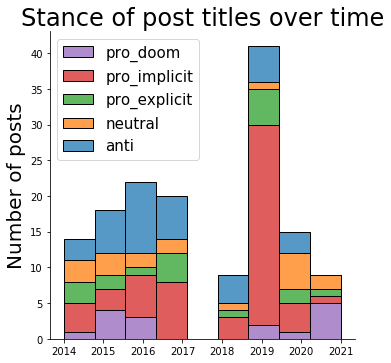

In [63]:
plt.rcParams['figure.figsize'] = [10, 14]
sns.displot(data=sample_with_labels_df.loc[sample_with_labels_df['label']
                                          .isin({'p','ps','pa','a','n'})],x='year',hue='label',multiple='stack',
           hue_order=['a','n','p','ps','pa'],legend=False)
plt.xlabel('')
plt.ylabel('Number of posts',fontsize=20)
plt.title('Stance of post titles over time',fontsize=24)
sns.despine()
plt.legend(title='', loc='upper left', labels=['anti', 'neutral', 'pro_explicit', 'pro_implicit',
                                                                  'pro_doom'][::-1],
          fontsize=15)
plt.savefig('figs/stance_manual_labels_over_time.png',dpi=200,bbox_inches="tight")